# Alanine dipeptide: MSM and hdbMSM

### In this notebook we show the essentials to obtain the MSM and hdbMSM corresponding to a previously run alanine dipeptide simulation.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [2]:
import mdtraj as md

### Analysis

In [3]:
root = os.path.expanduser("~") + "/Research/Projects/Peptides"
ff = "ff99sbildn"
traj = md.load_xtc("data/alatb_n1_ppn24.xtc", \
                   top="data/alaTB.gro")
print (traj)

<mdtraj.Trajectory with 400001 frames, 19 atoms, 3 residues, and unitcells>


In [4]:
import pyemma
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from pyemma.util.contexts import settings

pyemma.__version__

'2.5.7'

Take backbone torsion angles as features for MSM discretization.

In [5]:
topfile = "data/alaTB.gro"
feat = coor.featurizer(topfile)

In [6]:
feat.add_backbone_torsions()

In [7]:
feat.describe()

['PHI 0 ALA 2', 'PSI 0 ALA 2']

In [8]:
X = feat.transform(traj)

Carry out discretization by using K-means clustering with k=150 cluster centers.

In [9]:
kmeans = coor.cluster_kmeans(X, k=200, stride=5, max_iter=1000)

In [10]:
kmeans.cluster_centers_[:10]

array([[-2.2315385 , -0.654181  ],
       [-1.5432236 ,  2.8658316 ],
       [-2.5403762 ,  2.7905023 ],
       [-1.4078252 , -0.11295323],
       [-1.6367638 , -3.0711772 ],
       [-2.3314645 ,  0.42862856],
       [ 0.9682391 ,  0.7683413 ],
       [-1.320152  ,  1.629684  ],
       [-0.9953368 ,  2.549627  ],
       [-1.5561554 ,  2.0097783 ]], dtype=float32)

In [11]:
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

In [12]:
dtrajs

[array([ 30,  38,  91, ..., 118, 174,  49], dtype=int32)]

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


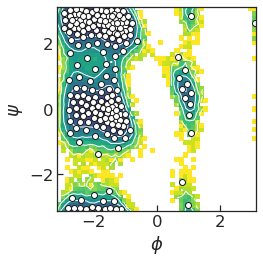

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
h, xedges, yedges, im = ax.hist2d(X[:,0], X[:,1], bins=[np.linspace(-np.pi, np.pi, 50), \
                                                        np.linspace(-np.pi, np.pi, 50)], \
          cmap='viridis_r', norm=mpl.colors.LogNorm(), density=True)
ax.contour(-np.transpose(np.log(h)), extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()], \
                  linewidths=1,  colors='white')
ax.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], lw=0, marker='o', mfc='w', mec='k')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
plt.tight_layout()
plt.savefig('../figures/alanine_dipeptide/kmeans.png', dpi=300, transparent=True)

### Traditional MSM construction

In [14]:
lags = range(1,50,5)

its_fine = msm.its(dtrajs, lags=lags, errors='bayes')

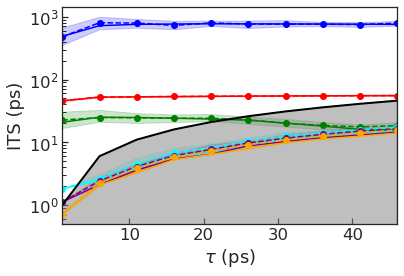

In [15]:
mplt.plot_implied_timescales(its_fine, show_mean=True, nits=6, ylog=True, units='ps', dt=1)
#plt.ylim(1,1200)
plt.ylabel('ITS (ps)')
plt.xlabel(r'$\tau$ (ps)')
plt.savefig('../figures/alanine_dipeptide/kmeans_its.png', dpi=300, transparent=True)

From the implied timescales (ITS) shown in the plot above, we consider that the MSM is already converged for $\tau$=10 ps.

In [16]:
M = msm.bayesian_markov_model(dtrajs, 10, dt_traj='1 ps')

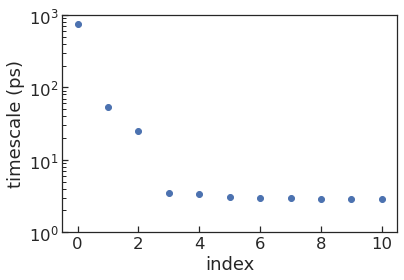

In [17]:
plt.plot(M.timescales(),linewidth=0,marker='o')
plt.xlabel('index')
plt.ylabel('timescale (ps)')
plt.xlim(-0.5,10.5)
plt.ylim(1,1000)
plt.yscale('log')
plt.savefig('../figures/alanine_dipeptide/kmeans_times.png', dpi=300, transparent=True)

Since there are three slow processes, let us lump the microstates into four macrostates by using PCCA+ spectral clustering. The resulting coarse-grained MSM is then validated by computing the corresponding Chapman-Kolmogorov test.

In [18]:
npcca = 4
M.pcca(npcca)

PCCA(P=array([[0.00565, 0.00142, ..., 0.01175, 0.00047],
       [0.00041, 0.01891, ..., 0.00054, 0.00473],
       ...,
       [0.00824, 0.00132, ..., 0.00924, 0.00066],
       [0.0005 , 0.01774, ..., 0.00101, 0.00304]]),
   m=4)

In [19]:
pcca_sets = M.metastable_sets

In [20]:
pcca_sets[0]

array([ 26,  27, 186])

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


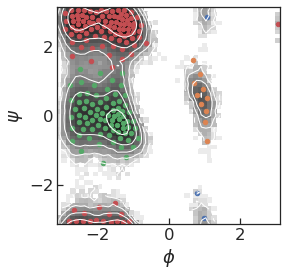

In [21]:
fig, ax = plt.subplots(figsize=(4,4), sharex=True)
h, xedges, yedges, im = ax.hist2d(X[:,0], X[:,1], bins=[np.linspace(-np.pi, np.pi, 50), \
                                                        np.linspace(-np.pi, np.pi, 50)], \
          cmap='binary', norm=mpl.colors.LogNorm(), density=True)
ax.contour(-np.transpose(np.log(h)), extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()], \
                  linewidths=1,  colors='white')
for i in range(npcca):
    ax.scatter(kmeans.cluster_centers_[pcca_sets[i],0], kmeans.cluster_centers_[pcca_sets[i],1], color='C%g'%i, s=20)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
plt.savefig('../figures/alanine_dipeptide/pcca.png', dpi=300, transparent=True)

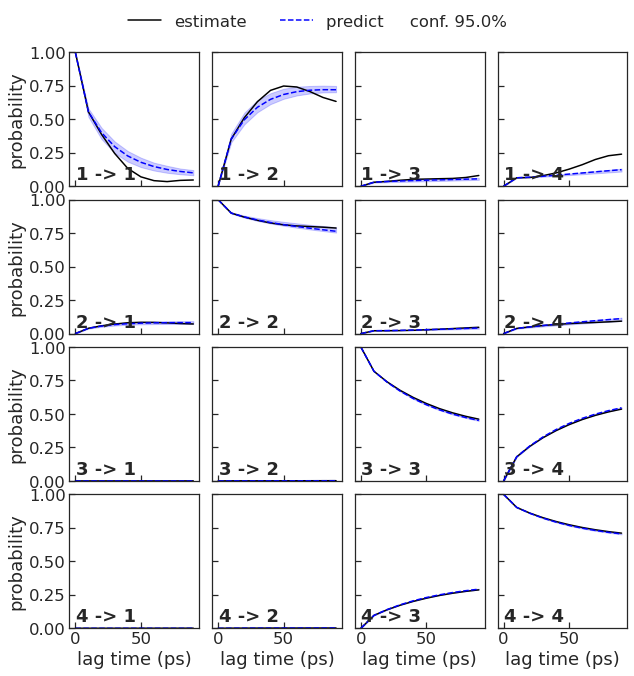

In [22]:
pyemma.plots.plot_cktest(M.cktest(4), units='ps', dt=1)
plt.savefig('../figures/alanine_dipeptide/pcca_ck.png', dpi=300, transparent=True)

### hdbMSM: MSM construction exploting density-based clustering

In [23]:
import hdbscan
import copy

Shift angles to avoid periodicity issues when clustering with HDBSCAN.

In [24]:
def shift(X):
    Xshift = copy.deepcopy(X)
    for i in range(len(Xshift)):
        if Xshift[i,1] < -2:
            Xshift[i,1] += 2*np.pi
        if Xshift[i,0] > 2:
            Xshift[i,0] -= 2*np.pi
    return Xshift

In [25]:
Xshift = shift(X)
np.min(Xshift[:,1]), np.min(X[:,1])

(-1.9932764, -3.1415923)

Apply HDBSCAN clustering with 'minimum cluster size' equal to 350 to previously normalized data. Feel free to modify yourself this parameter. Then look into resulting clusters.

In [26]:
from sklearn.preprocessing import StandardScaler
Y = StandardScaler().fit_transform(Xshift)

In [27]:
hdb = hdbscan.HDBSCAN(min_cluster_size=350).fit(Y)

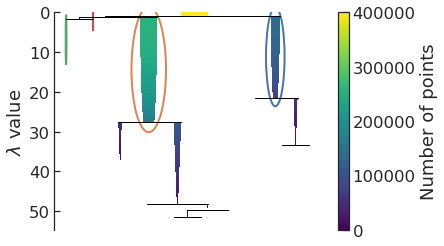

In [28]:
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.savefig('../figures/alanine_dipeptide/hdbscan_tree.png', dpi=300, transparent=True)

In [29]:
np.unique(hdb.labels_)

array([-1,  0,  1,  2,  3])

In order to be more stringent with the TBA methodology, let us set as 'noise' those points whose probability to be in their corresponding clusters is less than 30%.

In [30]:
for i in range(len(hdb.labels_)):
    if hdb.probabilities_[i] < 0.3:
        hdb.labels_[i] = -1

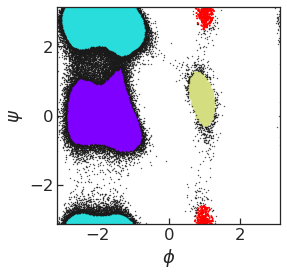

In [31]:
fig, ax = plt.subplots(figsize=(4,4))
assign = hdb.labels_ >= 0
ax.scatter(X[assign,0], X[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
nassign = hdb.labels_ == -1
ax.scatter(X[nassign,0], X[nassign,1], marker='.', 
                cmap='rainbow', s=0.5, c='k')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
plt.savefig('../figures/alanine_dipeptide/hdbscan.png', dpi=300, transparent=True)

Plot clusters projected onto backbone torsion angles along the trajectory to check if different regions are properly retrieved by HDBSCAN.

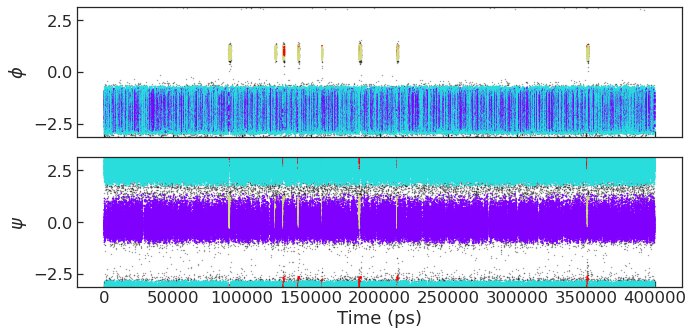

In [32]:
assign = hdb.labels_>= 0 
nassign = hdb.labels_ < 0

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
ax[0].scatter(np.arange(len(X[:,1]))[nassign], \
              X[nassign,0], s=0.15, c='k', alpha=0.5)
ax[0].scatter(np.arange(len(X[:,1]))[assign], \
              X[assign,0], s=0.5, cmap=cm.rainbow
        , c=hdb.labels_[assign])
ax[1].scatter(np.arange(len(X[:,1]))[nassign], \
              X[nassign,1], s=0.15, c='k', alpha=0.5)
ax[1].scatter(np.arange(len(X[:,1]))[assign], \
              X[assign,1], s=0.5, cmap=cm.rainbow
        , c=hdb.labels_[assign])
ax[0].set_ylabel('$\phi$')
ax[1].set_ylabel('$\psi$')
ax[1].set_xlabel('Time (ps)')
ax[1].set_ylim(-np.pi, np.pi)
plt.tight_layout()
plt.savefig('../figures/alanine_dipeptide/hdbscan_traj.png', dpi=300, transparent=True)

Construct hdbMSM and corresponding plots (ITS, relaxation times and Chapman-Kolmogorov test).

In [33]:
labels_tba = []
for i, l in enumerate(hdb.labels_):
    if l == -1:
        try:
            labels_tba.append(labels_tba[-1])
        except IndexError:
            pass
    else:
        labels_tba.append(l)

In [34]:
lags = range(1,50,5)
#its_hdb = msm.its(hdb.labels_[assign], lags=lags, errors='bayes')
its_hdb = msm.its(labels_tba, lags=lags, errors='bayes')

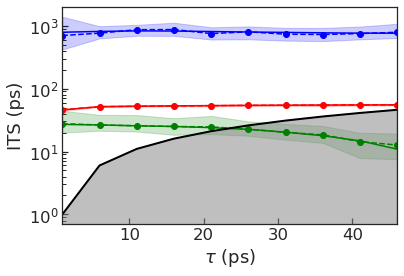

In [35]:
mplt.plot_implied_timescales(its_hdb, show_mean=True, nits=10, ylog=True, units='ps', dt=1)
#plt.ylim(0.1,1200)
plt.ylabel('ITS (ps)')
plt.xlabel(r'$\tau$ (ps)')
plt.savefig('../figures/alanine_dipeptide/hdbscan_its.png', dpi=300, transparent=True)

In [37]:
M = msm.bayesian_markov_model(labels_tba, 10, dt_traj='1 ps')

Note above that we estimate the MSM by excluding from the discrete trajectory those points that are considered 'noise', i.e. that do not belong to any HDBSCAN cluster.

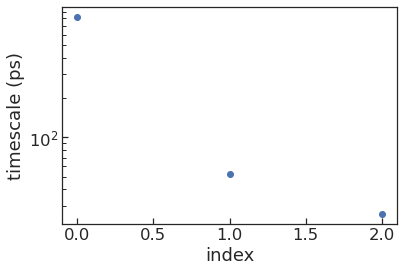

In [38]:
plt.plot(M.timescales(),linewidth=0,marker='o')
plt.xlabel('index')
plt.ylabel('timescale (ps)')
plt.yscale('log')
plt.savefig('../figures/alanine_dipeptide/hdbscan_times.png', dpi=300, transparent=True)

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


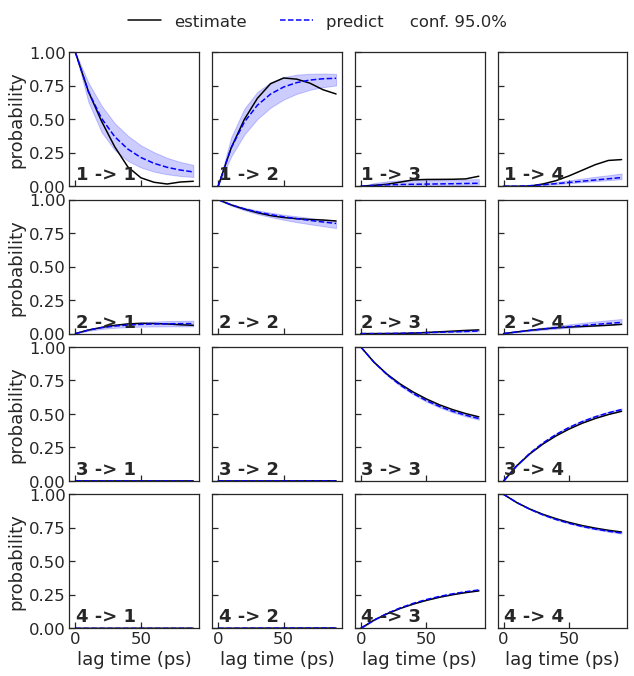

In [39]:
pyemma.plots.plot_cktest(M.cktest(4), units='ps', dt=1)
plt.savefig('../figures/alanine_dipeptide/hdbscan_ck.png', dpi=300, transparent=True)